In [9]:
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *
import time
from tqdm import tqdm
import seaborn as sns

# Implementation

In [2]:
dimensions = [5, 20, 50, 100]
num_points = 200

# Q (positive), b, and radius (delta).
def generate_pos_qbr(dimensions: list, num_points: int, feasible: bool = True):
    Qbrs = []
    for dim in dimensions:
        for _ in range(num_points):
            Q, b = generate_pos_Q_b(dim)
            unconstrained_x_opt = -np.linalg.inv(Q) @ b
            if feasible:
                delta = np.linalg.norm(unconstrained_x_opt) + np.random.random()
                Qbrs.append((Q, b, delta))
            else:
                delta = np.linalg.norm(unconstrained_x_opt) * np.random.random()
                Qbrs.append((Q, b, delta))
    return Qbrs

# Q (negative), b, and radius (delta).
def generate_neg_qbr(dimensions: list, num_points: int):
    Qbrs = []
    for dim in dimensions:
        for _ in range(num_points):
            Q, b = generate_neg_Q_b(dim)
            delta = np.random.random()
            Qbrs.append((Q, b, delta))
    return Qbrs

In [3]:
# the value for epsilon can affect the result of checking KKT conditions
# because in KKT conditions, we use np.isclose to check if the value is close to 0
# if epsilon is made larger, the parameter 'atol' in np.isclose should also be made larger to avoid false negative

def generate_results (qbrs: list, epsilon_scale: float = 1e-8):
    qbrx = []
    for qbr in qbrs:
        q, b, r = qbr
        epsilon = r * epsilon_scale
        try:
            x_opt = min_quad(q, b, r, epsilon)
            qbrx.append((q, b, r, x_opt))
        except Exception as e:
            print(e)
    return qbrx
    

def check_kkts (qbrx: list, atol: float = 1e-5):
    for qbrx in qbrx:
        q, b, r, x_opt = qbrx
        print("KKT: ", check_kkt(x_opt, q, b, r, atol))

def generate_timed_results (qbrs: list, epsilon_scale: float = 1e-8):
    qbrx = []
    times = []
    for qbr in qbrs:
        q, b, r = qbr
        epsilon = r * epsilon_scale
        try:
            start_time = time.time()
            x_opt = min_quad(q, b, r, epsilon)
            end_time = time.time()
            qbrx.append((q, b, r, x_opt))
            times.append(end_time - start_time)
        except Exception as e:
            # print(e)
            continue
    return qbrx, times

## Case 1: Q positive, unconstrained_min feasible

In [4]:
inputs_1 = generate_pos_qbr(dimensions, num_points, True)
# check_kkts(generate_results(inputs_1))

## Case 2: Q positive, unconstrained_min infeasible

In [5]:
inputs_2 = generate_pos_qbr(dimensions, num_points, False)
# check_kkts(generate_results(inputs_2))

## Case 3: Q negative, no unconstrained_min

In [6]:
inputs_3 = generate_neg_qbr(dimensions, num_points)
# check_kkts(generate_results(inputs_3))

# Benchmark

### Finding optimal value of epsilon

In [101]:
dimensions = [5, 20, 50, 100]
num_points = 200

epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
case1_times = []
case2_times = []

inputs_1 = generate_pos_qbr(dimensions, num_points, True)
inputs_2 = generate_pos_qbr(dimensions, num_points, False)

for e in tqdm(epsilons):
    _, c1_time = generate_timed_results(inputs_1, e)
    _, c2_time = generate_timed_results(inputs_2, e)
    
    case1_times.append(c1_time)
    case2_times.append(c2_time)

100%|██████████| 11/11 [02:54<00:00, 15.88s/it]


In [102]:
min_length = min([len(arr) for arr in case2_times])
tmp = []
for i in range(len(case2_times)):
    tmp.append(case2_times[i][:min_length-1])
case2_times = tmp

case1_times = np.array(case1_times)
case2_times = np.array(case2_times)

avg_case1_times = np.mean(case1_times, axis=1)
avg_case2_times = np.mean(case2_times, axis=1)

std_case1_times = np.std(case1_times, axis=1)
std_case2_times = np.std(case2_times, axis=1)

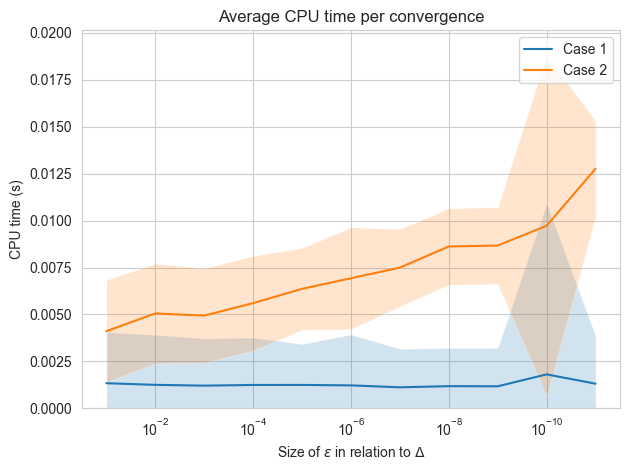

In [103]:
sns.set_style('whitegrid')

plt.plot(epsilons, avg_case1_times, label='Case 1')
plt.plot(epsilons, avg_case2_times, label='Case 2')
plt.fill_between(epsilons, avg_case1_times - std_case1_times, avg_case1_times + std_case1_times, alpha=0.2)
plt.fill_between(epsilons, avg_case2_times - std_case1_times, avg_case2_times + std_case1_times, alpha=0.2)

plt.title('Average CPU time per convergence')
plt.xlabel(r'Size of $\epsilon$ in relation to $\Delta$')
plt.ylabel('CPU time (s)')
plt.xscale('log')
plt.ylim(0)
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()